(graph-concepts)=
# Graph concepts and state machine

A graph is composed of the following:

* Step: A Step runs a function or class handler or a REST API call. MLRun comes with a list of [pre-built steps](./available-steps.html) that include data manipulation, readers, writers and model serving. You can also write your own steps using 
    standard Python functions or custom functions/classes, or can be a external REST API (the special `$remote` class).
* Router: A special type of step is a router with routing logic and multiple child routes/models. The basic 
    routing logic is to route to the child routes based on the `event.path`. More advanced or custom routing can be used,
    for example, the ensemble router sends the event to all child routes in parallel, aggregates the result and responds.
* Queue: A queue or stream that accepts data from one or more source steps and publishes to one or more output steps. 
    Queues are best used to connect independent functions/containers. Queues can run in-memory or be implemented using a stream, which allows it to span processes/containers.
    
The Graph server has two modes of operation (topologies):

* Router topology (default): A minimal configuration with a single router and child tasks/routes. This can be used for simple model serving or single hop configurations.
* Flow topology: A full graph/DAG. The flow topology is implemented using two engines: async (the default)
is based on [Storey](https://github.com/mlrun/storey) and asynchronous event loop; and `sync`, which supports a simple
sequence of steps.

**In this section**
- [The Event object](#the-event-object)
- [The Context object](#the-context-object)
- [Topology](#topology)
- [Building distributed graphs](#building-distributed-graphs)
- [Error handling](#error-handling)

## The Event object

The Graph state machine accepts an Event object (similar to a Nuclio Event) and passes 
it along the pipeline. An Event object hosts the event `body` along with other attributes 
such as `path` (http request path), `method` (GET, POST, ..), and`id` (unique event ID).

In some cases the events represent a record with a unique `key`, which can be read/set 
through the `event.key`.

The Task steps are called with the `event.body` by default. If a task step needs to 
read or set other event elements (key, path, time, ..) you should set the task `full_event`
argument to `True`.

Task steps support optional `input_path` and `result_path` attributes that allow controlling which portion of 
the event is sent as input to the step, and where to update the returned result.

For example, for an event body `{"req": {"body": "x"}}`, `input_path="req.body"` and `result_path="resp"` 
the step gets `"x"` as the input. The output after the step is `{"req": {"body": "x"}: "resp": <step output>}`.
Note that `input_path` and `result_path` do not work together with `full_event=True`.

## The Context object

The step classes are initialized with a `context` object (when they have `context` in their `__init__` args).
The context is used to pass data and for interfacing with system services. The context object has the 
following attributes and methods.

Attributes:
* **logger**: Central logger (Nuclio logger when running in Nuclio).
* **verbose**: True if in verbose/debug mode.
* **root**: The graph object.
* **current_function**: When running in a distributed graph, the current child function name.

Methods:
* **get_param(key, default=None)**: Get the graph parameter by key. Parameters are set at the
  serving function (e.g. `function.spec.parameters = {"param1": "x"}`).
* **get_secret(key)**: Get the value of a project/user secret.
* **get_store_resource(uri, use_cache=True)**: Get the mlrun store object (data item, artifact, model, feature set, feature vector).
* **get_remote_endpoint(name, external=False)**: Return the remote nuclio/serving function http(s) endpoint given its [project/]function-name[:tag].
* **Response(headers=None, body=None, content_type=None, status_code=200)**: Create a nuclio response object, for returning detailed http responses.

Example, using the context:

In [ ]:
if self.context.verbose:
    self.context.logger.info('my message', some_arg='text')
    x = self.context.get_param('x', 0)

## Topology

### Router
Once you have a serving function, you need to choose the graph topology. The default is `router` topology. With the `router` topology you can specify different machine learning models. Each model has a logical name. This name is used to route to the correct model when calling the serving function.

In [5]:
from sklearn.datasets import load_iris

# set the topology/router
graph = fn.set_topology("router")

# Add the model
fn.add_model("model1", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")

# Add additional models
#fn.add_model("model2", class_name="ClassifierModel", model_path="<path2>")

# create and use the graph simulator
server = fn.to_mock_server()
x = load_iris()['data'].tolist()
result = server.test("/v2/models/model1/infer", {"inputs": x})

print(result)

> 2021-11-02 04:18:36,925 [info] model model1 was loaded
> 2021-11-02 04:18:36,926 [info] Initializing endpoint records
> 2021-11-02 04:18:36,965 [info] Loaded ['model1']
{'id': '6bd11e864805484ea888f58e478d1f91', 'model_name': 'model1', 'outputs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}


### Flow

Using the `flow` topology, you can specify tasks, which typically manipulate the data. The most common scenario is pre-processing of data prior to the model execution.

```{note} Once the topology is set, you cannot change an existing function topology.
```

In this topology, you build and connect the graph (DAG) by adding steps using the `step.to()` method, or by using the 
`graph.add_step()` method.

> The `step.to()` is typically used to chain steps together. `graph.add_step` can add steps anywhere on the
> graph and has `before` and `after` parameters to specify the location of the step.

<!-- show example without router -->

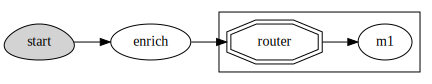

In [18]:
fn2 = mlrun.code_to_function("serving_example_flow",
                             kind="serving", 
                             image="mlrun/mlrun")

graph2 = fn2.set_topology("flow")     

graph2_enrich = graph2.to("storey.Extend", name="enrich", _fn='({"tag": "something"})')

# add an Ensemble router with two child models (routes)
router = graph2.add_step(mlrun.serving.ModelRouter(), name="router", after="enrich")
router.add_route("m1", class_name="ClassifierModel", model_path='https://s3.wasabisys.com/iguazio/models/iris/model.pkl')
router.respond()

# Add additional models
#router.add_route("m2", class_name="ClassifierModel", model_path=path2)

# plot the graph (using Graphviz)
graph2.plot(rankdir='LR')

In [7]:
fn2_server = fn2.to_mock_server()

result = fn2_server.test("/v2/models/m1/infer", {"inputs": x})

print(result)

> 2021-11-02 04:18:42,142 [info] model m1 was loaded
> 2021-11-02 04:18:42,142 [info] Initializing endpoint records
> 2021-11-02 04:18:42,183 [info] Loaded ['m1']
{'id': 'f713fd7eedeb431eba101b13c53a15b5'}


## Building distributed graphs

Graphs can be hosted by a single function (using zero to n containers), or span multiple functions
where each function can have its own container image and resources (replicas, GPUs/CPUs, volumes, etc.).
It has a `root` function, which is where you configure triggers (http, incoming stream, cron, ..), 
and optional downstream child functions.

You can specify the `function` attribute in `Task` or `Router` steps. This indicates where 
this step should run. When the `function` attribute is not specified it runs on the root function.</b>
`function="*"` means the step can run in any of the child functions.

Steps on different functions should be connected using a `Queue` step (a stream).

**Adding a child function:**

In [ ]:
fn.add_child_function('enrich', 
                      './entity_extraction.ipynb', 
                      image='mlrun/mlrun',
                      requirements=["storey", "sklearn"])

See a [full example with child functions](./model-serving-get-started.html#example-nlp-processing-pipeline-with-real-time-streaming).  

A distributed graph looks like this:

![distributed graph](../_static/images/graph-distributed.png)

## Error handling

Graph steps might raise an exception. If you want to have an error handling flow,
you can specify an exception handling step/branch that is triggered on error.
The error handler step receives the event that entered the failed step, with two extra
attributes: `event.origin_state` indicates the name of the failed step; and `event.error`
holds the error string.

Use the `graph.error_handler()` (apply to all steps) or `step.error_handler()` 
(apply to a specific step) if you want the error from the graph or the step to be 
fed into a specific step (catcher).

Example of setting an error catcher per step:

In [ ]:
graph.add_step("MyClass", name="my-class", after="pre-process").error_handler("catcher")
graph.add_step("ErrHandler", name="catcher", full_event=True, after="")

  
```{note}
Additional steps can follow the `catcher` step.
```

Using the example in [Model serving graph](./model-serving-get-started.html#flow), you can add an error handler as follows:

In [ ]:
graph2_enrich.error_handler("catcher")
graph2.add_step("ErrHandler", name="catcher", full_event=True, after="")

Now, display the graph again:

In [ ]:
graph2.plot(rankdir='LR')

### Exception stream

The graph errors/exceptions can be pushed into a special error stream. This is very convenient 
in the case of distributed and production graphs.

To set the exception stream address (using v3io streams uri):

In [ ]:
fn_preprocess2.spec.error_stream = err_stream